# Model Comparison — Multi-Model Sentiment Analysis

1. Setup — imports & environment
2. Load Data — import preprocessed data from Oracle
3. Model Configuration — define models and device
4. Load Models — initialize sentiment analysis pipelines
5. Sentiment Analysis — run all models on dataset
6. Ensemble Metrics — compute mean, variance, std across models
7. Explode Tickers — one row per ticker mention
8. Model Statistics — descriptive statistics by model
9. Visualizations — sentiment distributions, model agreement, trends<br>
    9.1 Sentiment Score Distributions by Model<br>
    9.2 Model Correlation Heatmap<br>
    9.3 Sentiment by Subreddit<br>
    9.4 Top Tickers by Volume and Sentiment<br>
    9.5 Sentiment Over Time<br>
10. Export Results — save to CSV

**Output:** `sentiment_multi_model.csv`


## 1 Setup — Imports & Environment

Load required libraries and configure environment.


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import oracledb
from dotenv import load_dotenv
from utils import get_oracle_connection
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

load_dotenv()
tqdm.pandas()


/Users/simon2/.pyenv/versions/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:utils:spaCy model loaded successfully
INFO:utils:spaCy model loaded successfully


## 2 Load Data — Import Preprocessed Data

Load preprocessed data from Oracle database table `preprocessed_data`.


In [2]:
conn = get_oracle_connection()

query = """
SELECT
    ID,
    DBMS_LOB.SUBSTR(SENTIMENT_READY_TEXT, 20000, 1) as SENTIMENT_READY_TEXT,
    TYPE,
    SUBREDDIT,
    CREATED_UTC,
    NORMALIZED_UPVOTES,
    DBMS_LOB.SUBSTR(MENTIONED_TICKERS, 100, 1) as MENTIONED_TICKERS,
    N_TICKERS,
    TEXT_LENGTH,
    WORD_COUNT,
    DATE_COL,
    HOUR,
    DAY_OF_WEEK
FROM preprocessed_data
FETCH FIRST 1000 ROWS ONLY
"""

df = pd.read_sql_query(query, conn)
conn.close()

df.columns = df.columns.str.lower()
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
if 'date_col' in df.columns:
    df['date'] = pd.to_datetime(df['date_col'])
    df.drop(columns=['date_col'], inplace=True)

print(f"Loaded {len(df)} rows")
df.head()

Oracle connection successful!


/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_80214/98098836.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Loaded 1000 rows


,id,sentiment_ready_text,type,subreddit,created_utc,normalized_upvotes,mentioned_tickers,n_tickers,text_length,word_count,hour,day_of_week,date
0,m48hiu4,I'd considering splitting it across two banks ...,comment,investing,2024-12-28 19:22:19,0.018399,UBS,1,241,47,19,5,2024-12-28
1,m48hedi,I had the opportunity for the IPO price thing ...,comment,stocks,2024-12-28 19:21:38,0.011074,AMD,1,75,15,19,5,2024-12-28
2,m48heet,"Looks like It's down, but the 6 month chart sh...",comment,investing,2024-12-28 19:21:38,0.018076,KO,1,286,50,19,5,2024-12-28
3,m48gxg1,Just look at 52 week lows. Stock screeners wil...,comment,ValueInvesting,2024-12-28 19:19:04,0.056502,HSY,1,278,51,19,5,2024-12-28
4,m48guco,Are you looking to index? Wealthfront has a ne...,comment,investing,2024-12-28 19:18:36,0.018076,UBS,1,82,15,19,5,2024-12-28


## 3 Model Configuration

Define sentiment analysis models and detect available device (GPU/CPU).


In [3]:
MODEL_NAMES = {
    "finbert": "ProsusAI/finbert",
    "finbert_tone": "yiyanghkust/finbert-tone",
    "roberta_financial": "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    "twitter_roberta": "cardiffnlp/twitter-roberta-base-sentiment-latest"
}

device = 0 if torch.cuda.is_available() else -1


## 4 Load Models — Initialize Pipelines

Load all sentiment analysis models and create pipeline objects.


In [4]:
pipelines = {}

for name, model_name in MODEL_NAMES.items():
    tok = AutoTokenizer.from_pretrained(model_name)
    mod = AutoModelForSequenceClassification.from_pretrained(model_name)
    pipelines[name] = pipeline(
        "text-classification",
        model=mod,
        tokenizer=tok,
        device=device,
        return_all_scores=True,
        truncation=True,
        max_length=256
    )


Device set to use cpu
/Users/simon2/.pyenv/versions/py311/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/Users/simon2/.pyenv/versions/py311/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are 

## 5 Sentiment Analysis — Batch Classification

Define classification function and run all models on the dataset.


In [5]:
def classify_batch(pipe, texts):
    outputs = pipe(texts)
    results = []
    for out in outputs:
        probs = {d["label"].lower(): float(d["score"]) for d in out}
        results.append({
            "label": max(probs, key=probs.get),
            "score": probs.get("positive", 0.0) - probs.get("negative", 0.0),
            "p_pos": probs.get("positive", 0.0),
            "p_neu": probs.get("neutral", 0.0),
            "p_neg": probs.get("negative", 0.0)
        })
    return results


In [6]:
BATCH_SIZE = 32
texts = df["sentiment_ready_text"].fillna("").astype(str).tolist()

for model_name, pipe in pipelines.items():
    labels, scores, ppos, pneu, pneg = [], [], [], [], []

    for start in tqdm(range(0, len(texts), BATCH_SIZE), desc=model_name):
        batch = texts[start:start+BATCH_SIZE]
        out = classify_batch(pipe, batch)
        for r in out:
            labels.append(r["label"])
            scores.append(r["score"])
            ppos.append(r["p_pos"])
            pneu.append(r["p_neu"])
            pneg.append(r["p_neg"])

    df[f"{model_name}_label"] = labels
    df[f"{model_name}_score"] = scores
    df[f"{model_name}_p_pos"] = ppos
    df[f"{model_name}_p_neu"] = pneu
    df[f"{model_name}_p_neg"] = pneg


twitter_roberta: 100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


## 6 Ensemble Metrics — Cross-Model Statistics

Compute mean, variance, and standard deviation across all model scores.


In [7]:
score_cols = [f"{m}_score" for m in MODEL_NAMES.keys()]
df["sentiment_mean"] = df[score_cols].mean(axis=1)
df["sentiment_variance"] = df[score_cols].var(axis=1)
df["sentiment_std"] = df[score_cols].std(axis=1)


## 7 Explode Tickers — One Row Per Ticker

Convert mentioned_tickers from comma-separated string to list and explode to create one row per ticker mention.


In [14]:
df['mentioned_tickers'] = df['mentioned_tickers'].apply(
    lambda x: x if isinstance(x, list) else [t.strip() for t in str(x).split(',') if t.strip()]
)
df = df.explode('mentioned_tickers').reset_index(drop=True)

print(f"Number of rows: {len(df)}")


Number of rows: 1950


## 8 Model Statistics — Descriptive Analysis

Display descriptive statistics for each model's sentiment scores.


In [15]:
df[score_cols].describe()


,finbert_score,finbert_tone_score,roberta_financial_score,twitter_roberta_score
count,1950.000000,1950.000000,1950.000000,1950.000000
mean,0.034130,0.102736,0.126470,0.081884
std,0.321154,0.474762,0.531853,0.482404
min,-0.966383,-0.999999,-0.998139,-0.932559
25%,-0.043469,-0.001713,-0.000033,-0.250399
50%,0.023657,-0.000021,0.000007,0.070083
75%,0.117287,0.013767,0.130357,0.408824
max,0.936626,1.000000,0.999533,0.984019


## 9 Visualizations

Visualize sentiment distributions, model agreement, and key patterns.


### 9.1 Sentiment Score Distributions by Model


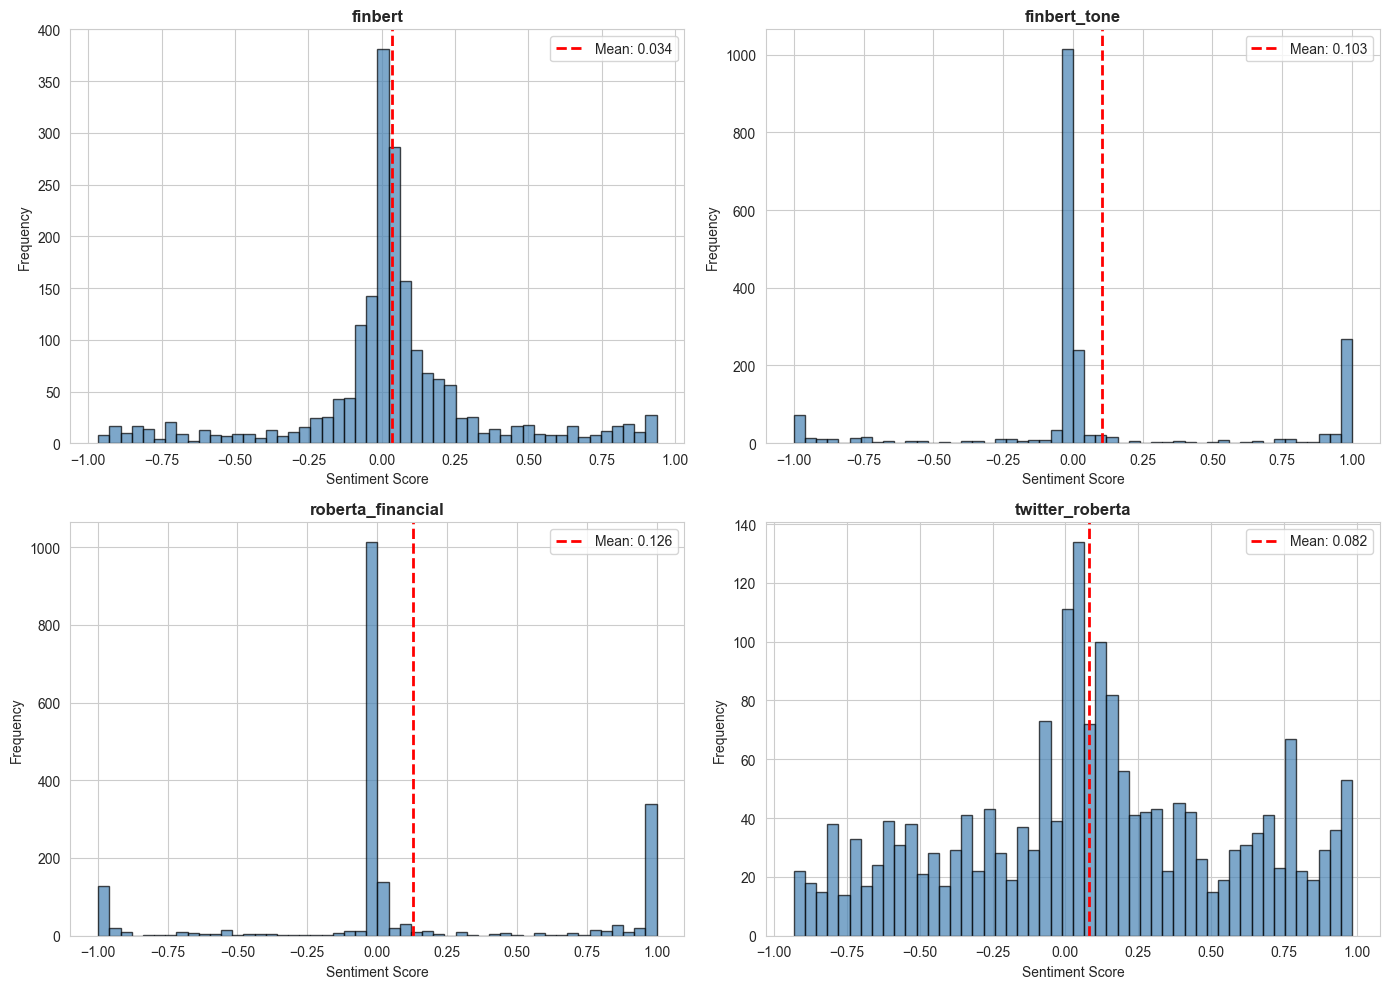

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, model_key in enumerate(MODEL_NAMES.keys()):
    score_col = f"{model_key}_score"
    axes[idx].hist(df[score_col], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].axvline(df[score_col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[score_col].mean():.3f}')
    axes[idx].set_title(f'{model_key}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Sentiment Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.show()


### 9.2 Model Correlation Heatmap


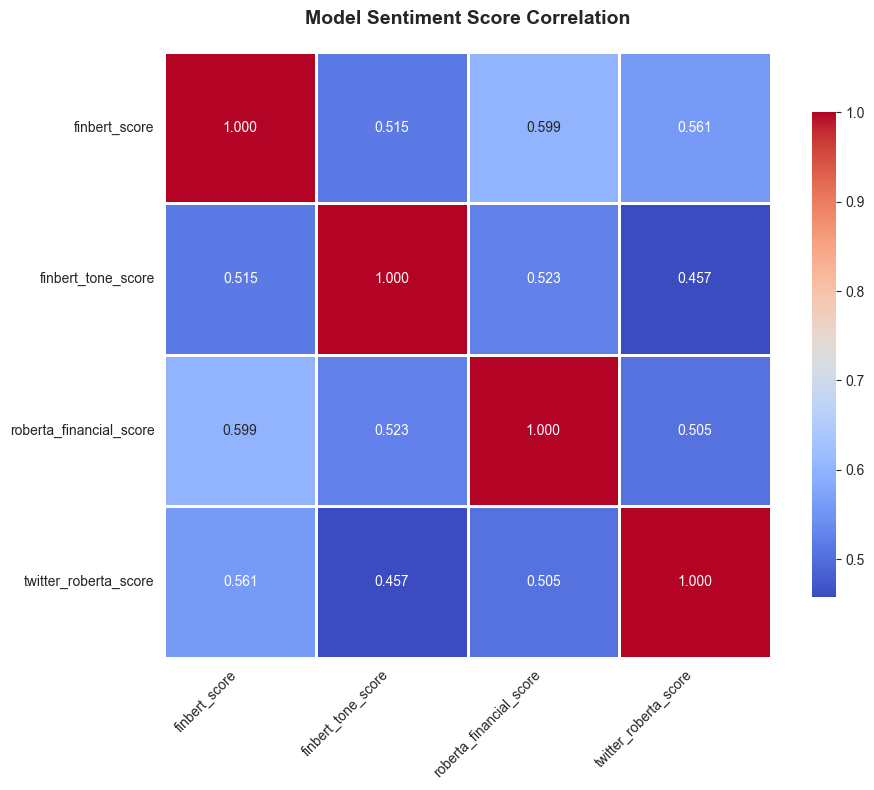

In [20]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[score_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Model Sentiment Score Correlation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 9.3 Sentiment by Subreddit


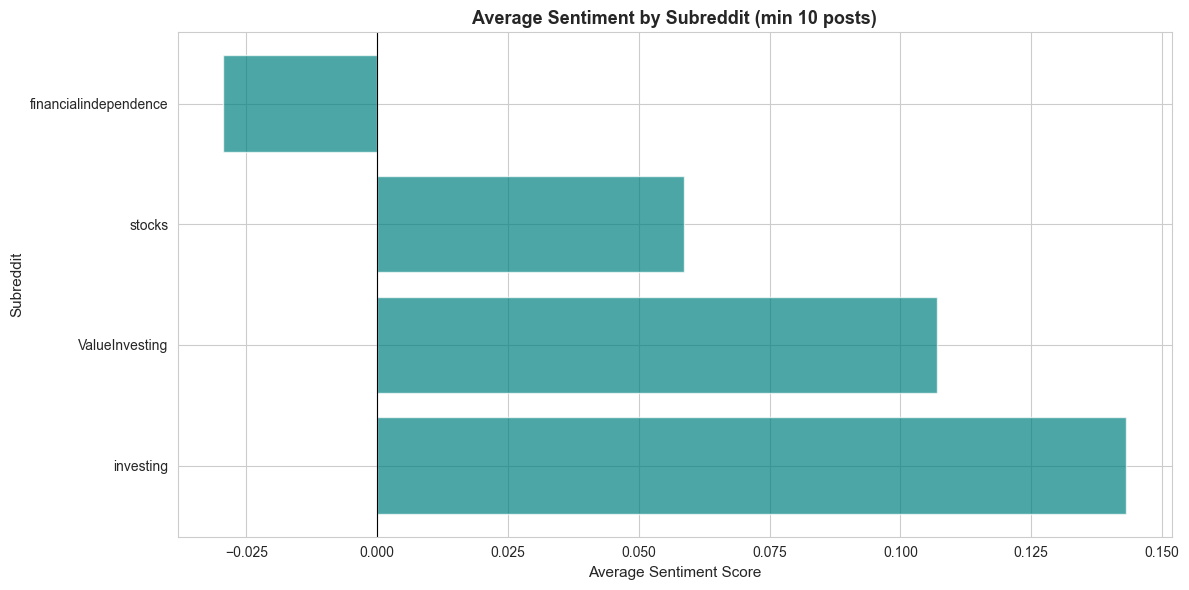

In [22]:
subreddit_sentiment = df.groupby('subreddit')['sentiment_mean'].agg(['mean', 'count']).reset_index()
subreddit_sentiment = subreddit_sentiment[subreddit_sentiment['count'] >= 10].sort_values('mean', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.barh(subreddit_sentiment['subreddit'], subreddit_sentiment['mean'], color='teal', alpha=0.7)
plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Average Sentiment Score', fontsize=11)
plt.ylabel('Subreddit', fontsize=11)
plt.title('Average Sentiment by Subreddit (min 10 posts)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


### 9.4 Top Tickers by Volume and Sentiment


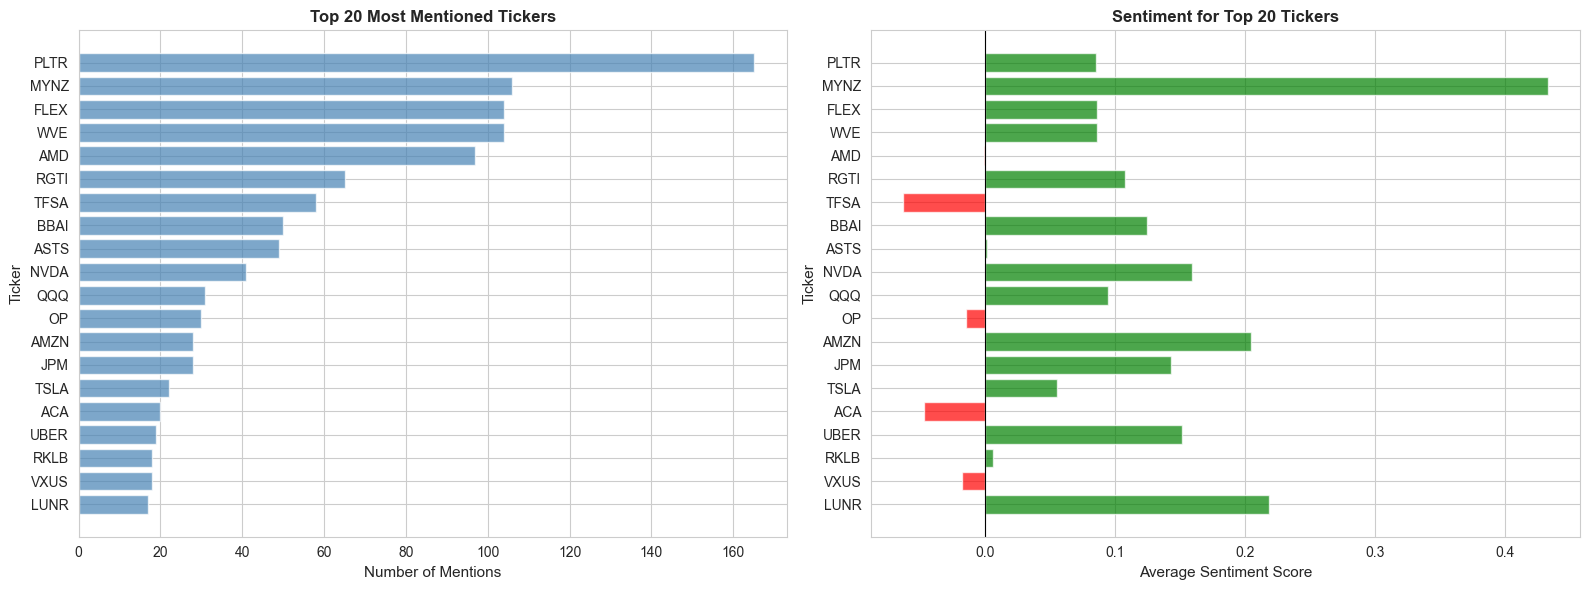

In [23]:
ticker_stats = df.groupby('mentioned_tickers').agg({
    'sentiment_mean': 'mean',
    'id': 'count'
}).rename(columns={'id': 'mentions'}).reset_index()

top_tickers = ticker_stats.nlargest(20, 'mentions')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.barh(top_tickers['mentioned_tickers'], top_tickers['mentions'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Number of Mentions', fontsize=11)
ax1.set_ylabel('Ticker', fontsize=11)
ax1.set_title('Top 20 Most Mentioned Tickers', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

colors = ['green' if x > 0 else 'red' for x in top_tickers['sentiment_mean']]
ax2.barh(top_tickers['mentioned_tickers'], top_tickers['sentiment_mean'], color=colors, alpha=0.7)
ax2.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Average Sentiment Score', fontsize=11)
ax2.set_ylabel('Ticker', fontsize=11)
ax2.set_title('Sentiment for Top 20 Tickers', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


### 9.5 Sentiment Over Time


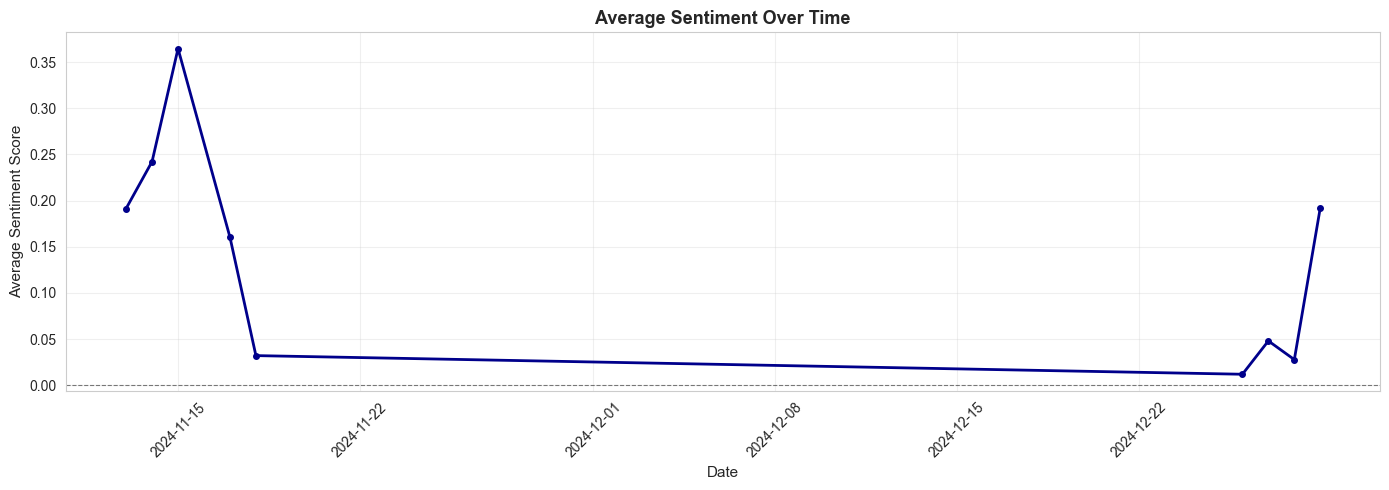

In [24]:
df['date_only'] = df['date'].dt.date
daily_sentiment = df.groupby('date_only')['sentiment_mean'].mean().reset_index()

plt.figure(figsize=(14, 5))
plt.plot(daily_sentiment['date_only'], daily_sentiment['sentiment_mean'],
         linewidth=2, color='darkblue', marker='o', markersize=4)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Average Sentiment Score', fontsize=11)
plt.title('Average Sentiment Over Time', fontsize=13, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 10 Export Results — Save to CSV

Export final dataset with all model predictions to CSV file.


In [25]:
df.to_csv("sentiment_multi_model.csv", index=False)
print(f"Exported {len(df)} rows to sentiment_multi_model.csv")


Exported 1950 rows to sentiment_multi_model.csv
